# Long Term EMA Crossover System

Philosophy:
The system intends to catch the longer term (i.e. several months or more) large percentage moves in a stock as it gets revalued by the market.
Trends are signalled using an EMA crossover, combined with a selection of fundamental filters to improve performance.
    

In [1]:
# Set up global imports including related packages
import matplotlib.pyplot as plt
import pandas as pd
# Ignore warnings from pandas about assigning to copy of dataframe
pd.set_option('mode.chained_assignment', None)
import sys
import os
sys.path.append(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\FinancialDataHandling\\financial_data_handling"))
os.chdir(os.path.join("C:\\Users", os.getlogin(), "Source\\Repos\\EnsembleSystemDevelopment\\ensemble_trading_system"))

# Data storage
from store.file_system import Storage
# System imports
from data_types.market import Market
from system.core import Strategy, Portfolio
from system.core import VolatilityMultiplier, SizingStrategy
from measures.moving_averages import EMA
from measures.volatility import StdDevEMA
from measures.valuations import ValueRatio
from signals.level_signals import Crossover
from rules.signal_rules import PositionFromDiscreteSignal
from trade_modifiers.exit_conditions import StopLoss, TrailingStop, ReturnTriggeredTrailingStop
from trade_modifiers.filters import HighPassFilter
# Import analysis tools
from system.analysis import summary_report, cross_validate_portfolio
# Set up default plot parameters
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 5)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Strategy Assessment
The base assessment uses data from the NYSE up to the end of 2015. This data is considered the in-sample period. Once system settings are finalised the performance is re-assessed on the remainder of the NYSE data as well as on ASX data (out of sample).

The base strategy uses an EMA crossover to indicate entries and exits. Trade calculations are conducted at the Close, and trading is conducted at the Open.

In [2]:
store = Storage("NYSE")
# Base System configuration
strategy = Strategy(trade_timing = "O", ind_timing = "C")
strategy.market = Market(store)
strategy.signal_generator = Crossover(slow = EMA(150), fast = EMA(75))
strategy.position_rules = PositionFromDiscreteSignal(Up = 1)

# Run the strategy
strategy.run()
print("Generated {} trades.".format(strategy.trades.count))

Generated 4075 trades.


In [3]:
# Store the baseline results
buy_and_hold_trades = strategy.buy_and_hold_trades()
buy_and_hold_returns = strategy.market_returns
base_trades = strategy.trades
base_returns = strategy.returns

### Signals
This section contains assessment of the ability of the strategy signals to generate the desired trade profile (e.g. in terms of statistics such as duration, winning percentage, win/loss ratio), as well as the ability of the signals to add performance vs the market.
#### Parameter fuzzing
The base parameters of the strategy are varied to determine the sensitivity of performance and to gauge the suitable parameter settings to attain the desired trade characteristics.

In [ ]:
from system.analysis import ParameterFuzzer
fuzzer = ParameterFuzzer(strategy, base_parameters = (120, 50), processes = 2)
#fuzzer.fuzzed_pars = [(200, 160), (200, 100), (200, 40), (150, 120), (150, 75), (150, 30), (100, 80), (100, 50), (100, 20)]
fuzzer.fuzzed_pars = [(200, 160), (200, 100)]
fuzzer.summarise()

In [ ]:
# Assess effect of parameters on winning percentage and win/loss ratio
fig, axarr = plt.subplots(1, 3)
fuzzer.plot_metric('Number of trades', ax = axarr[0])
fuzzer.plot_metric('Percent winners', ax = axarr[1])
fuzzer.plot_metric('Ratio average win to loss', ax = axarr[2])

#### Sensitivity analysis
Sensitivity analysis checks the variation in performance of the base strategy with changes in the market constituents. A number of random sub-samples (of tickers) are taken to determine if the overall performance is driven by only a few good results.

In [4]:
from system.analysis import Sampler
sampler = Sampler(N = 200, subset_fraction = 0.5)
sampler.check_robustness(strategy.returns)

Running 200 samples: ........................................................................................................................................................................................................
done.


(<matplotlib.figure.Figure at 0x2cbe375f358>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002CBE3961DA0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002CBEE486940>], dtype=object))

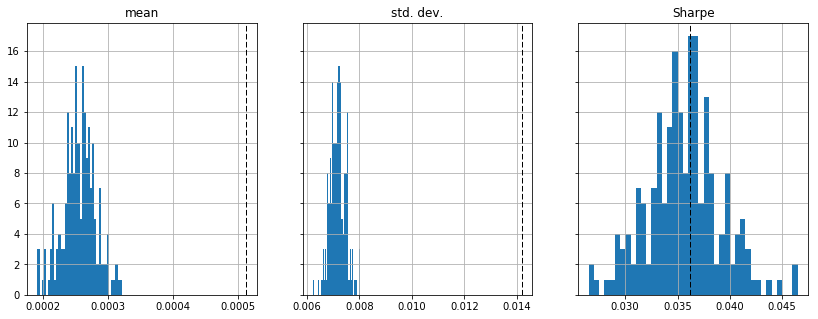

In [5]:
sampler.sample_hist(bins = 40)

### Filters
#### Investigate performance vs filter values
Assess the ability of the selected filters to improve performance without limiting the number of trades too much.


In [6]:
# Load the filter data
adjusted = ValueRatio('EPV', 'Adjusted')(strategy)
cyclic = ValueRatio('EPV', 'Cyclic')(strategy)
from system.analysis import FilterPerformance
fp = FilterPerformance(strategy.trades)
fp.add(adjusted, cyclic)
adjusted_results = fp.summarise(adjusted.name, bins = [-1000, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2, 1000])
cyclic_results = fp.summarise(cyclic.name, bins = [-1000, -2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2, 1000])

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\categorical.py:1841: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._constructor(values=self._codes[key],


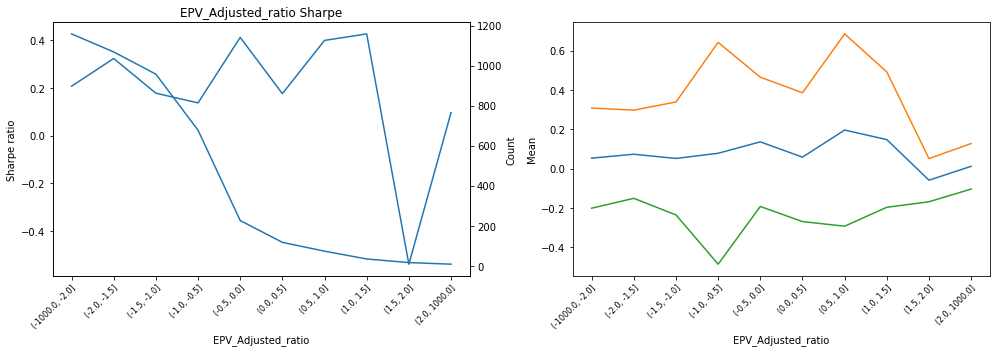

In [18]:
# Review the performance vs Adjusted EPV
fig, axarr = plt.subplots(1, 2)
fp.result = adjusted_results
fp.plot_Sharpe(ax = axarr[0])
fp.plot_count(ax = axarr[0])
fp.plot_mean(ax = axarr[1])
fp.set_x_labels(axarr[0])
fp.set_x_labels(axarr[1])
plt.tight_layout()

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\categorical.py:1841: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return self._constructor(values=self._codes[key],


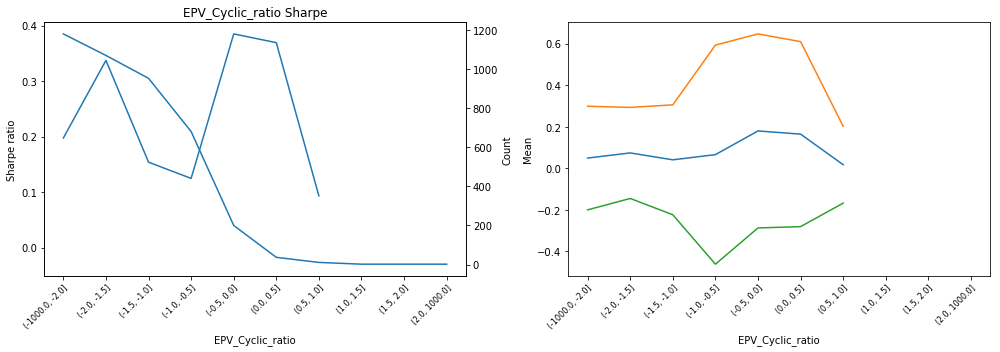

In [19]:
# Review the performance vs Cyclic EPV
fig, axarr = plt.subplots(1, 2)
fp.result = cyclic_results
fp.plot_Sharpe(ax = axarr[0])
fp.plot_count(ax = axarr[0])
fp.plot_mean(ax = axarr[1])
fp.set_x_labels(axarr[0])
fp.set_x_labels(axarr[1])
plt.tight_layout()

#### Filter robustness
We try to assess whether the filter performance was achieved only through chance. Random samples of the same size as the filtered trades are taken from the base set of trades. The distribution of the random samples is then plotted against the filtered results.

In [9]:
# Configure and apply filters
strategy.apply_filter(HighPassFilter(adjusted, -0.5))
filtered_trades = strategy.trades
filtered_returns = strategy.returns
print('Filtered down to {} trades'.format(filtered_trades.count))

Filtered down to 226 trades


Running 200 samples: ........................................................................................................................................................................................................
done.


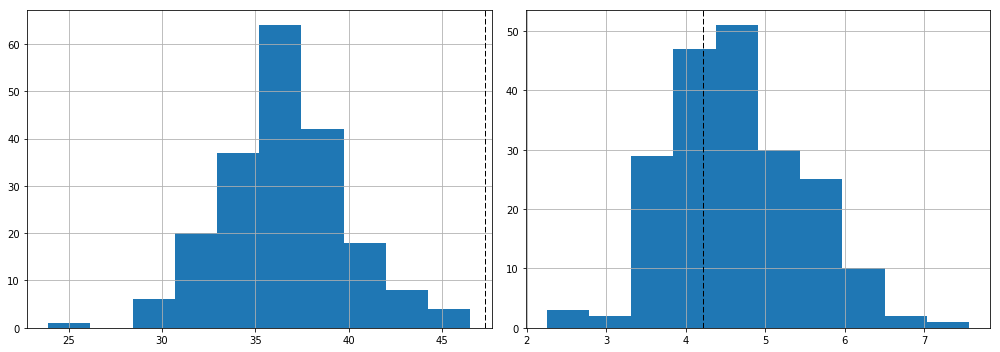

In [10]:
# Run the sampler on the filtered trades
sampler.check_selection_skill(filtered_trades, base_trades)
fig, axarr = plt.subplots(1, 2)
sampler.skill_hist('Percent winners', ax = axarr[0])
sampler.skill_hist('Ratio average win to loss', ax = axarr[1])
plt.tight_layout()



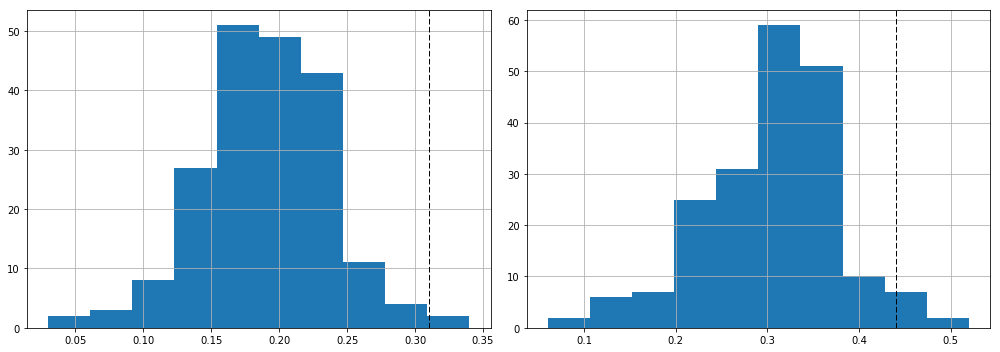

In [11]:
fig, axarr = plt.subplots(1, 2)
sampler.skill_hist('Sharpe by trade inc slippage', ax = axarr[0])
sampler.skill_hist('Sharpe annualised inc slippage', ax = axarr[1])
plt.tight_layout()

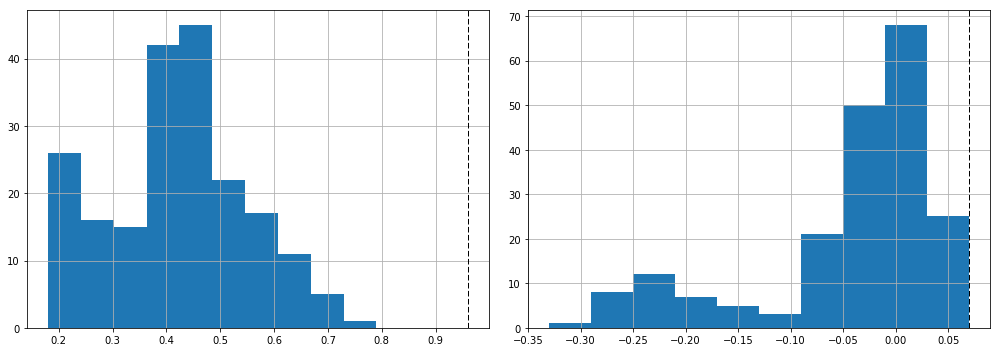

In [12]:
fig, axarr = plt.subplots(1, 2)
sampler.skill_hist('Opt F', ax = axarr[0])
sampler.skill_hist('Geom. growth rate', ax = axarr[1])
plt.tight_layout()

In [ ]:
# Print trade statistics
summary = summary_report(
    Buy_and_hold = buy_and_hold_trades, 
    Base_strategy = base_trades,
    Filters_added = filtered_trades
)
print(summary)

### Stops
#### Stop loss

In [ ]:
# Plot the maximum adverse excursion and maximum favourable excursion for the filtered trades.
base_trades.plot_MAE() # blue
filtered_trades.plot_MAE() # orange

Definitely some scope for stop losses, potentially at around 15%

In [ ]:
# Analysis of various stop loss settings
from system.analysis import test_stop_loss, test_trailing_stop
stop_loss_summary = test_stop_loss(strategy, [0.3, 0.2, 0.15, 0.1, 0.05, 0.02])
print(stop_loss_summary)

Suprisingly still good results even with a tight 2% stop, however best seems to be around 10%

#### Trailing stops

In [ ]:
# Plot maximum favourable excursion to check typical end trade drawdowns.
base_trades.plot_MFE() # blue
filtered_trades.plot_MFE() # orange

### TODO
Should look at maximum intra-trade drawdown, vs end of trade drawdown to determine suitable trailing stops.

Larger trades will typically give up more than 10% (base system), and 20-30% (filtered system).

In [ ]:
# Trailing stop analysis
trailing_stop_summary = test_trailing_stop(strategy, [0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.02])
print(trailing_stop_summary)

Interestingly the Sharpe ratio (exluding slippage) and optimal F ratio continue to increase with tighter trailing stops.
However the typical trade duration and average return drops too far.
A trailing stop of 10-15% seems to be appropriate.

In [ ]:
# Add stops and compare results
strategy.apply_exit_condition(StopLoss(0.1))
strategy.apply_exit_condition(TrailingStop(0.1))
stopped_trades = strategy.trades
stopped_returns = strategy.returns
summary['StopLoss_added'] = summary_report(stopped_trades)
print(summary)

In [ ]:
filtered_trades.hist(bins = 20)
stopped_trades.hist(bins = 20)

In [ ]:
filtered_trades.plot_MAE()
stopped_trades.plot_MAE()

In [ ]:
# Comparing biggest winners
max_filtered = filtered_trades.returns.max()
max_stopped = stopped_trades.returns.max()
max_filtered = filtered_trades.find(lambda t: t.base_return == max_filtered)[0]
max_stopped = stopped_trades.find(lambda t: t.base_return == max_stopped)[0]
fig, axarr = plt.subplots(nrows = 2, ncols = 1, sharex = True)
max_filtered.cumulative.plot(ax = axarr[0], color = 'magenta')
max_filtered.plot_highwater(ax = axarr[0], color = 'red')
max_filtered.plot_drawdowns(ax = axarr[1], color = 'magenta')
max_stopped.cumulative.plot(ax = axarr[0], color = 'cyan')
max_stopped.plot_highwater(ax = axarr[0], color = 'blue')
max_stopped.plot_drawdowns(ax = axarr[1], color = 'cyan')
fig.tight_layout()

In [ ]:
# Comparing biggest losers
min_filtered = filtered_trades.returns.min()
min_stopped = stopped_trades.returns.min()
min_filtered = filtered_trades.find(lambda t: t.base_return == min_filtered)[0]
min_stopped = stopped_trades.find(lambda t: t.base_return == min_stopped)[0]
fig, axarr = plt.subplots(nrows = 2, ncols = 1, sharex = True)
min_filtered.cumulative.plot(ax = axarr[0], color = 'magenta')
min_filtered.plot_highwater(ax = axarr[0], color = 'red')
min_filtered.plot_drawdowns(ax = axarr[1], color = 'magenta')
min_stopped.cumulative.plot(ax = axarr[0], color = 'cyan')
min_stopped.plot_highwater(ax = axarr[0], color = 'blue')
min_stopped.plot_drawdowns(ax = axarr[1], color = 'cyan')
fig.tight_layout()

## Portfolio Analysis

In [ ]:
portfolio = Portfolio(strategy, 15000)
portfolio.sizing_strategy = SizingStrategy(diversifier = 0, min_size = 2500, max_size = 0.25)
portfolio.run()

In [ ]:
portfolio.plot_result()

In [ ]:
f, axarr = plt.subplots(1, 2, figsize = (16, 5))
portfolio.summary[portfolio.trade_start_date:].plot(ax = axarr[0])
portfolio.positions.num_concurrent()[portfolio.trade_start_date:].plot(ax = axarr[1])
plt.tight_layout()

In [ ]:
portfolio_base_trades = portfolio.trades

In [ ]:
# Add volatility sizing to the portfolio
volatilities = StdDevEMA(40)(strategy.indicator_prices.at(strategy.trade_entry))
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.2, volatilities))
portfolio.reset()
portfolio.run()
portfolio_vol_tgt_20 = portfolio.trades
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_vol_tgt_30 = portfolio.trades

In [ ]:
portfolio_summary = summary_report(
    Base = portfolio_base_trades, 
    Vol20 = portfolio_vol_tgt_20, 
    Vol30 = portfolio_vol_tgt_30
)
print(portfolio_summary)

In [ ]:
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.2, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_2 = portfolio.trades
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.5, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_5 = portfolio.trades
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.8, min_size = 2500, max_size = 0.3)
portfolio.sizing_strategy.multipliers.append(VolatilityMultiplier(0.3, volatilities))
portfolio.reset()
portfolio.run()
portfolio_trades_8 = portfolio.trades
portfolio_summary2 = summary_report(
    Div2 = portfolio_trades_2, 
    Div5 = portfolio_trades_5, 
    Div8 = portfolio_trades_8
)
print(portfolio_summary2)

In [ ]:
portfolio.sizing_strategy = SizingStrategy(diversifier = 0.5, min_size = 2500, max_size = 0.3)
portfolio.reset()
portfolio.run()
_, axarr = plt.subplots(1, 2, figsize = (16, 5))
portfolio.summary[portfolio.trade_start_date:].plot(ax = axarr[0])
portfolio.positions.num_concurrent()[portfolio.trade_start_date:].plot(ax = axarr[1])
plt.tight_layout()

In [ ]:
portfolio.max_position_percent()[portfolio.trade_start_date:].plot()

In [ ]:
portfolio.returns.plot_monthly(start = portfolio.trade_start_date, values = ['mean', 'std', 'sharpe'])

In [ ]:
x_summary = cross_validate_portfolio(portfolio, N = 30)
x_summary['portfolio'].sharpe().hist(bins = 20)
x_summary['market'].sharpe().hist(bins = 20)

In [ ]:
x_summary['portfolio'].final().hist(bins = 20)
x_summary['market'].final().hist(bins = 20)

In [ ]:
x_summary['portfolio'].drawdowns()
